In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import time
import os
import numpy as np

Dataset Overview

In [2]:
data = pd.read_csv(r"C:\Users\karol\OneDrive\Dokumenty\Barcelona\automatic_learning\train_A_derma.csv", header=None)

In [3]:
 data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Id,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Doughnuts consumption,Fake/Real
1,0,1.0,-1.2771300077438354,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1.2341247768940422,real
2,1,NaN,-1.8420699834823608,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1.216755888782292,real
3,2,NaN,-1.8229000568389893,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1.2643416905006748,real
4,3,1.0,-1.3604899644851685,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.1268424184448358,real


In [4]:
 data.shape

(598, 13)

Ground truth

In [5]:
labels = data[12]

In [6]:
labels.unique()

array(['Fake/Real', 'real', 'fake'], dtype=object)

Drop the Ground Truth Column from the Dataset

In [7]:
data_ = data.drop(12, axis=1)

In [8]:
data_.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,Id,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Doughnuts consumption
1,0,1.0,-1.2771300077438354,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1.2341247768940422
2,1,NaN,-1.8420699834823608,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1.216755888782292
3,2,NaN,-1.8229000568389893,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1.2643416905006748
4,3,1.0,-1.3604899644851685,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.1268424184448358


In [11]:
ids = data_[0]

In [16]:
data1 = data_.drop(0, axis = 1)


In [18]:
data1.head()

,1,2,3,4,5,6,7,8,9,10,11
0,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Doughnuts consumption
1,1.0,-1.2771300077438354,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1.2341247768940422
2,NaN,-1.8420699834823608,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1.216755888782292
3,NaN,-1.8229000568389893,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1.2643416905006748
4,1.0,-1.3604899644851685,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.1268424184448358


C:\Users\karol\AppData\Local\Temp\ipykernel_20852\3208893248.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(nan_counts.index.astype(str), rotation=90)


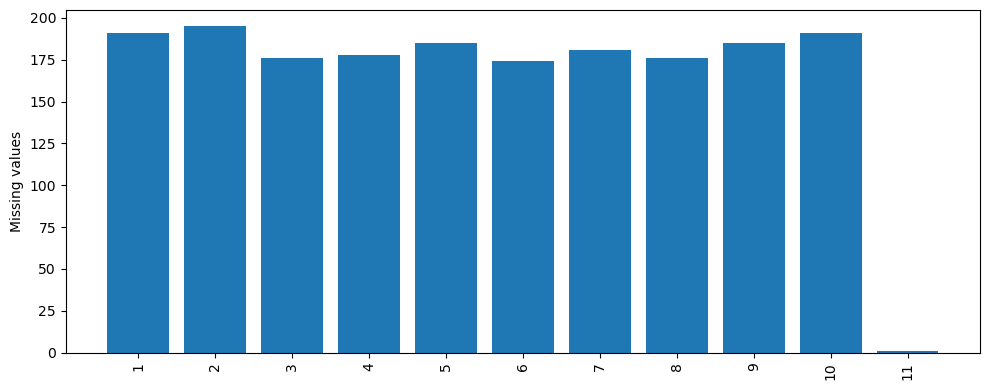

In [24]:
numeric = data1.apply(pd.to_numeric, errors='coerce')  # teksty -> NaN
nan_counts = numeric.isna().sum()

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(nan_counts.index.astype(str), nan_counts.values)
ax.set_ylabel('Missing values')
ax.set_xticklabels(nan_counts.index.astype(str), rotation=90)
plt.tight_layout()
plt.show()


In [27]:
df = data1.copy()

missing_pct = df.isna().mean().sort_values(ascending=False)
missing_count = df.isna().sum().sort_values(ascending=False)
print(missing_pct)
print(missing_count)
print("rows:", len(df))
print("rows without any NA:", df.dropna().shape[0])

2     0.324415
1     0.317726
10    0.317726
5     0.307692
9     0.307692
7     0.301003
4     0.295987
3     0.292642
8     0.292642
6     0.289298
11    0.000000
dtype: float64
2     194
1     190
10    190
5     184
9     184
7     180
4     177
3     175
8     175
6     173
11      0
dtype: int64
rows: 598
rows without any NA: 22


In [31]:
# prepare
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # required
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

df = data1.copy()          # twoje data_trim
df = df.reset_index(drop=True)

# exclude identifiers and target
ID_COL = 'Id'
TARGET = 'Fake/Real'
feature_cols = [c for c in df.columns if c not in [ID_COL, TARGET]]

# 1) create missing flags
for c in feature_cols:
    df[c + '_was_missing'] = df[c].isna().astype(int)

# 2) decide which columns to impute with IterativeImputer
#    separate numeric and categorical for safe encoding
num_cols = df[feature_cols].select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols]

# 3) encode categorical columns if any (OrdinalEncoder used for simplicity)
if cat_cols:
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df[cat_cols] = enc.fit_transform(df[cat_cols].astype(object))

# 4) choose columns to feed to IterativeImputer (exclude the newly created flags)
cols_for_impute = [c for c in num_cols + cat_cols if not c.endswith('_was_missing')]

# 5) run IterativeImputer with a tree estimator for nonlinear relations
imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=20, random_state=0),
                       max_iter=10, sample_posterior=False, random_state=0)
df[cols_for_impute] = imp.fit_transform(df[cols_for_impute])

# 6) optional: if you used OrdinalEncoder, inverse transform when needed
#    enc.inverse_transform(df[cat_cols])  # only if needed and values valid




TypeError: unsupported operand type(s) for +: 'int' and 'str'